In [9]:
# Importing libraries...
import math
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
SHOW_CLOUD = True

training_dir = "/Users/sidharthagarwal/Desktop/assignments/ml774/Assignment2/Q1/part1_data/train" #str(sys.argv[1])
testing_dir  = "/Users/sidharthagarwal/Desktop/assignments/ml774/Assignment2/Q1/part1_data/test"  #str(sys.argv[2])

In [10]:
# Initializing variables..

def restartModel():
    wordFreq = {}
    wordFreq[0] = {}
    wordFreq[1] = {}

    totalFreq = {}
    totalFreq[0] = 0
    totalFreq[1] = 0

    totalDocs = {}
    totalDocs[0] = 0
    totalDocs[1] = 1

    alpha = 1
    posCloudText = ""
    negCloudText = ""

    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    vocabulary = 0
    
    return wordFreq,totalFreq,totalDocs,alpha,posCloudText,negCloudText,TP,FP,TN,FN,vocabulary

wordFreq,totalFreq,totalDocs,alpha,posCloudText,negCloudText,TP,FP,TN,FN,vocabulary = restartModel()

def resultAnalysis(TP,FP,TN,FN):
    prec = TP/(TP+FP)
    rec  = TP/(TP+FN)
    print("The precision is : "+str(prec))
    print("The recall is : "+str(rec))
    print("The F1 score is : "+str((2*prec*rec)/(prec+rec)))

In [11]:
# Training the model
def trainModel(path,label,wordFreq,totalFreq,totalDocs,preprocessing = False,featuring = False):
    
    listOfFiles = os.listdir(path)
    for fileName in listOfFiles:
        
        file = open(os.path.join(path,fileName),"r")
        text = file.read()
        word_list = re.split(' |,|\\.|\n|:|;|"|\'|`|{{|}}|[|]|\)|\(',text)
        
        new_word_list = []
        for word in word_list:
            
            if preprocessing:
                word = ps.stem(word.lower())
                if word in stop_words:
                    continue
                
            if word not in wordFreq[label]:
                wordFreq[label][word] = 0
                
            wordFreq[label][word] += 1
            totalFreq[label] += 1
            new_word_list.append(word)
        
        if featuring:
            prevWord = new_word_list[0]
            for word in new_word_list[1:]:
                bigram = prevWord + "|" + word
                prevWord = word
                
                if bigram not in wordFreq[label]:
                    wordFreq[label][bigram] = 0
                
                wordFreq[label][bigram]  += 1
                totalFreq[label] += 1
        
    totalDocs[label] += len(listOfFiles)

trainModel(training_dir+"/pos",1,wordFreq,totalFreq,totalDocs)
trainModel(training_dir+"/neg",0,wordFreq,totalFreq,totalDocs)    

In [12]:
# Testing the model

def predictLabel(path,wordFreq,totalFreq,totalDocs,isPosCloud,preprocessing,featuring):
    global posCloudText
    global negCloudText
    
    file = open(path,"r")
    text = file.read()
    word_list = re.split(' |,|\\.|\n|:|;|"|\'|`|{{|}}|[|]|\)|\(',text)
    
    positive_prob = 0
    negative_prob = 0
    
    new_word_list = []
    for word in word_list:
        
        if preprocessing:
            word = ps.stem(word.lower())
            if word in stop_words:
                continue
        
        if SHOW_CLOUD and isPosCloud and len(posCloudText)<10000:
            posCloudText += word + " "
        elif SHOW_CLOUD and not isPosCloud and len(negCloudText)<10000:
            negCloudText += word + " "
        
        posFreq = alpha if word not in wordFreq[1] else wordFreq[1][word] + alpha
        negFreq = alpha if word not in wordFreq[0] else wordFreq[0][word] + alpha
        
        positive_prob += math.log(posFreq) - math.log(totalFreq[1] + alpha*vocabulary)
        negative_prob += math.log(negFreq) - math.log(totalFreq[0] + alpha*vocabulary)
        
        new_word_list.append(word)
    
    if featuring:
        prevWord = new_word_list[0]
        for word in new_word_list[1:]:
            bigram = prevWord + "|"+ word
            prevWord = word
            
            posFreq = alpha if bigram not in wordFreq[1] else wordFreq[1][bigram] + alpha
            negFreq = alpha if bigram not in wordFreq[0] else wordFreq[0][bigram] + alpha
            
            positive_prob += math.log(posFreq) - math.log(totalFreq[1] + alpha*vocabulary)
            negative_prob += math.log(negFreq) - math.log(totalFreq[0] + alpha*vocabulary)
            
    positive_prob +=  -1*math.log(totalDocs[0])
    negative_prob +=  -1*math.log(totalDocs[1])
    
    if positive_prob>=negative_prob:
        return 1
    return 0
        
    
def prediction(path,wordFreq,totalFreq,totalDocs,preprocessing = False,featuring = False):
    global TP,TN,FP,FN
    correct = 0
    total = 0
    
    pos_path = path + "/pos"
    listOfPos = os.listdir(pos_path)
    for fileName in listOfPos:
        thisLabel = predictLabel(os.path.join(pos_path,fileName),wordFreq,totalFreq,totalDocs,True,preprocessing,featuring)
        if(thisLabel==1):
            correct += 1
            TP += 1
        else:
            FN += 1
    total += len(listOfPos)
    
    neg_path = path + "/neg"
    listOfNeg = os.listdir(neg_path)
    for fileName in listOfNeg:
        thisLabel = predictLabel(os.path.join(neg_path,fileName),wordFreq,totalFreq,totalDocs,False,preprocessing,featuring)
        if(thisLabel==0):
            correct += 1
            TN += 1
        else:
            FP += 1
    total += len(listOfNeg)
    
    print("The accuracy is : "+str(correct/total))

vocabulary = len(set(list(wordFreq[0].keys()) + list(wordFreq[1].keys())))
print("For training dataset: ")
#prediction(training_dir,wordFreq,totalFreq,totalDocs)
print("For testing dataset: ")
prediction(testing_dir,wordFreq,totalFreq,totalDocs)


For training dataset: 
For testing dataset: 
The accuracy is : 0.7974


In [ ]:
# wordclouds

wordcloud = WordCloud(width = 800, height = 800, background_color ='white',stopwords = set(),
          min_font_size = 10).generate(posCloudText)

plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Positive label")
plt.savefig("1a_wordcloud_pos.png")

wordlcoud = WordCloud(width = 800, height = 800, background_color ='white',stopwords = set(),
          min_font_size = 10).generate(negCloudText)

plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Negative label")
plt.savefig("1a_wordcloud_neg.png")

In [ ]:
# Qb

totalPosB = len(os.listdir(testing_dir + "/pos"))
totalNegB = len(os.listdir(testing_dir + "/neg"))

print("For b.i the accuracy will be : 0.5")
print("For b.ii the accuracy will be : "+str(totalPosB/(totalPosB+totalNegB)))

In [ ]:
# Qc

def printConfusion(TP,FP,TN,FN):
    confDict = {"1":[TP,FN],"0":[FP,TN]}
    df = pd.DataFrame(confDict)
    df.index = ["1","0"]
    print(df)

print("For part a: ")
printConfusion(TP,FP,TN,FN)

print("\nFor part b random: ")
printConfusion(totalPosB/2,totalPosB/2,totalNegB/2,totalNegB/2)

print("\nFor part b only positive: ")
printConfusion(totalPosB,totalNegB,0,0)

In [13]:
#Qd

print("For part a: ")
resultAnalysis(TP,FP,TN,FN)

wordFreq,totalFreq,totalDocs,alpha,posCloudText,negCloudText,TP,FP,TN,FN,vocabulary = restartModel()
trainModel(training_dir+"/pos",1,wordFreq,totalFreq,totalDocs,True)
trainModel(training_dir+"/neg",0,wordFreq,totalFreq,totalDocs,True)

vocabulary = len(set(list(wordFreq[0].keys()) + list(wordFreq[1].keys())))
print("\n\nFor part d: ")
print("Accuracy For training dataset: ")
#prediction(training_dir,wordFreq,totalFreq,totalDocs,True)
print("Accuracy For testing dataset: ")
prediction(testing_dir,wordFreq,totalFreq,totalDocs,True)

print("For part d: ")
resultAnalysis(TP,FP,TN,FN)

For part a: 
The precision is : 0.9241925655088361
The recall is : 0.7583
The F1 score is : 0.833067838505905


For part d: 
Accuracy For training dataset: 
The accuracy is : 0.914
Accuracy For testing dataset: 
The accuracy is : 0.8102
For part d: 
The precision is : 0.9299857514862674
The recall is : 0.8412444444444445
The F1 score is : 0.8833920612325858


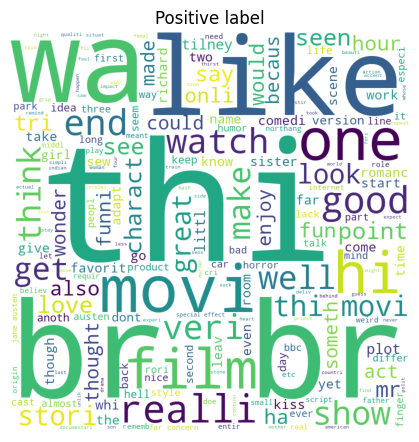

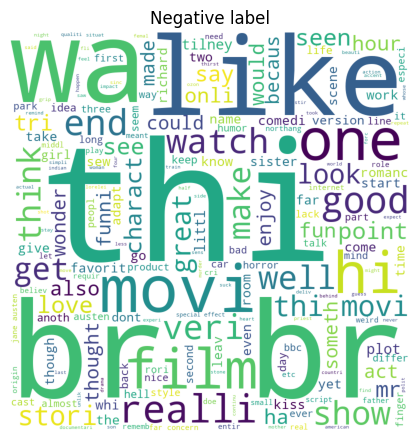

In [8]:
# wordclouds

wordcloud = WordCloud(width = 800, height = 800, background_color ='white',stopwords = set(),
          min_font_size = 10).generate(posCloudText)

plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Positive label")
plt.savefig("1d_wordcloud_pos.png")

wordlcoud = WordCloud(width = 800, height = 800, background_color ='white',stopwords = set(),
          min_font_size = 10).generate(negCloudText)

plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Negative label")
plt.savefig("1d_wordcloud_neg.png")

In [15]:
# Qe

wordFreq,totalFreq,totalDocs,alpha,posCloudText,negCloudText,TP,FP,TN,FN,vocabulary = restartModel()
trainModel(training_dir+"/pos",1,wordFreq,totalFreq,totalDocs,True,True)
trainModel(training_dir+"/neg",0,wordFreq,totalFreq,totalDocs,True,True)

vocabulary = len(set(list(wordFreq[0].keys()) + list(wordFreq[1].keys())))

print("\n\nFor part e: ")
print("Accuracy For training dataset: ")
#prediction(training_dir,wordFreq,totalFreq,totalDocs,True,True)

print("Accuracy For testing dataset: ")
prediction(testing_dir,wordFreq,totalFreq,totalDocs,True,True)

print("For part e: ")
resultAnalysis(TP,FP,TN,FN)




For part e: 
Accuracy For training dataset: 
Accuracy For testing dataset: 
The accuracy is : 0.841
For part e: 
The precision is : 0.9440233236151604
The recall is : 0.8095
The F1 score is : 0.8716016150740242


In [ ]:
# Qf
#def resultAnalysis(TP,FP,TN,FN):
#    prec = TP/(TP+FP)
#    rec  = TP/(TP+FN)
#    print("The precision is : "+str(prev))
#    print("The recall is : "+str(rec))
#    print("The F1 score is : "+str((2*prec*rec)/(prec+rec)))